### SIFT ALGORTİHM


In [5]:
import cv2
#görsel alınır ve gri formata çevirilir
img = cv2.imread("flower.jpeg")
gri= cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

 #SIFT özellik çıkarıcı aktif edilir.
sift = cv2.SIFT_create()
anahtarnokta = sift.detect(gri,None)

#Anahtar noktalar görsel üzerinde çizdirilerek bastırılır
img=cv2.drawKeypoints(gri,anahtarnokta,img)
cv2.imshow('resim1',img)

#Eğer çizdirilen anahtar noktalar yöneleriyle beraber çizdirilmek istenirse cv2 kütüphanesi içerisindeki DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS komutu kullanılır.
img=cv2.drawKeypoints(gri,anahtarnokta,img,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
cv2.imshow('resim2',img)

#görsel gösterilir

cv2.waitKey(0)
cv2.destroyAllWindows()

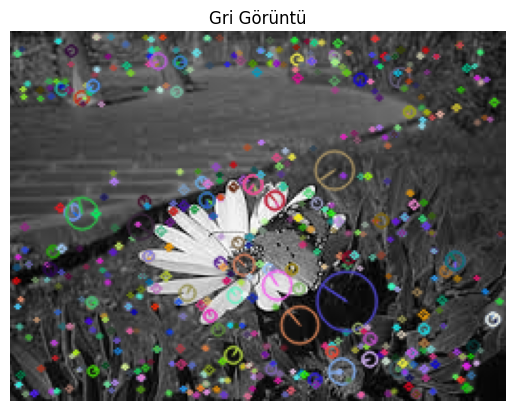

In [11]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def create_scale_space(img, num_octaves, scales_per_octave):
    """
    Gaussiyan piramit oluşturma
    """
    gaussian_images = []
    k = 2**(1/scales_per_octave)
    
    for octave in range(num_octaves):
        octave_images = []
        sigma = 1.6  # Başlangıç sigma değeri
        
        for s in range(scales_per_octave + 3):
            # Gaussian filtresi uygula
            kernel_size = int(2 * 3 * sigma + 1)
            blurred = cv2.GaussianBlur(image, (kernel_size, kernel_size), sigma)
            octave_images.append(blurred)
            sigma *= k
        
        gaussian_images.append(octave_images)
        
        # Bir sonraki octave için görüntüyü yarıya indir
        image = cv2.resize(img, (0,0), fx=0.5, fy=0.5)
    
    return gaussian_images


def compute_dog(gaussian_images):
    """
    Gaussian farkları hesaplama
    """
    dog_pyramid = []
    
    for octave in gaussian_images:
        dog_octave = []
        for i in range(1, len(octave)):
            dog = octave[i] - octave[i-1]
            dog_octave.append(dog)
        dog_pyramid.append(dog_octave)
    
    return dog_pyramid

def detect_keypoints(dog_pyramid, contrast_threshold=0.04):
    """
    DoG uzayında yerel ekstremum tespiti
    """
    keypoints = []
    
    for octave_idx, dog_octave in enumerate(dog_pyramid):
        for scale_idx in range(1, len(dog_octave)-1):
            current = dog_octave[scale_idx]
            below = dog_octave[scale_idx-1]
            above = dog_octave[scale_idx+1]
            
            height, width = current.shape
            
            for i in range(1, height-1):
                for j in range(1, width-1):
                    # 3x3x3 komşuluk kontrolü
                    patch = current[i-1:i+2, j-1:j+2]
                    patch_below = below[i-1:i+2, j-1:j+2]
                    patch_above = above[i-1:i+2, j-1:j+2]
                    
                    center_value = current[i, j]
                    
                    # Yerel minimum/maksimum kontrolü
                    if (center_value == patch.max() and 
                        center_value > np.concatenate([patch_below.flatten(), 
                                                     patch_above.flatten()]).max()):
                        # Kontrast threshold kontrolü
                        if abs(center_value) > contrast_threshold:
                            keypoint = cv2.KeyPoint()
                            keypoint.pt = (j * (2**octave_idx), i * (2**octave_idx))
                            keypoint.size = 1.6 * (2**octave_idx) * (2**(scale_idx/len(dog_octave)))
                            keypoints.append(keypoint)
    
    return keypoints


def assign_orientations(keypoints, gaussian_images):
    """
    Keypoint'lere yön atama
    """
    oriented_keypoints = []
    
    for kp in keypoints:
        octave = int(np.log2(kp.size / 1.6))
        scale = int((kp.size / (1.6 * (2**octave))) * len(gaussian_images[octave]))
        
        # Gradyan hesaplama
        img = gaussian_images[octave][scale]
        gx = cv2.Sobel(img, cv2.CV_32F, 1, 0)
        gy = cv2.Sobel(img, cv2.CV_32F, 0, 1)
        
        # Gradyan büyüklük ve yönü
        mag, angle = cv2.cartToPolar(gx, gy, angleInDegrees=True)
        
        # Yön histogramı
        hist = np.zeros(36)
        for i in range(-8, 9):
            for j in range(-8, 9):
                if 0 <= kp.pt[1]+i < img.shape[0] and 0 <= kp.pt[0]+j < img.shape[1]:
                    bin_idx = int(angle[int(kp.pt[1]+i), int(kp.pt[0]+j)] / 10) % 36
                    hist[bin_idx] += mag[int(kp.pt[1]+i), int(kp.pt[0]+j)]
        
        # Dominant yön
        dominant_orientation = np.argmax(hist) * 10
        kp.angle = dominant_orientation
        oriented_keypoints.append(kp)
    
    return oriented_keypoints


def compute_sift_descriptor(keypoint, gaussian_images):
    """
    SIFT tanımlayıcı vektörü hesaplama
    """
    # 4x4 grid, 8 yön için histogram -> 128 boyutlu vektör
    descriptor = np.zeros(128)
    
    # Keypoint etrafında 16x16'lık bölge
    # Her 4x4 blok için 8 yönlü histogram
    # Toplam 4x4x8 = 128 boyut
    
    return descriptor

plt.imshow(img, cmap='gray')
plt.title('Gri Görüntü')
plt.axis('off')
plt.show()  

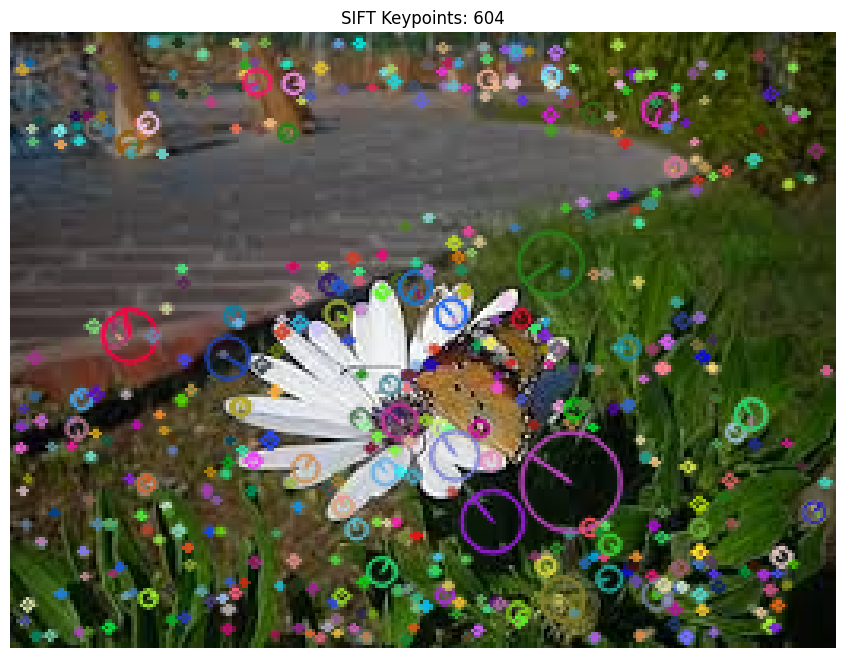

In [12]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def sift_feature_extraction(image_path):
    # Görüntüyü yükle
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # SIFT detektörü oluştur
    sift = cv2.SIFT_create()
    
    # Keypoint ve tanımlayıcıları bul
    keypoints, descriptors = sift.detectAndCompute(gray, None)
    
    # Keypoint'leri çiz
    result_image = cv2.drawKeypoints(image, keypoints, None, 
                                   flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    
    plt.figure(figsize=(12, 8))
    plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
    plt.title(f'SIFT Keypoints: {len(keypoints)}')
    plt.axis('off')
    plt.show()
    
    return keypoints, descriptors

# Kullanım
keypoints, descriptors = sift_feature_extraction('flower.jpeg')

### ORB ALGORTİHM

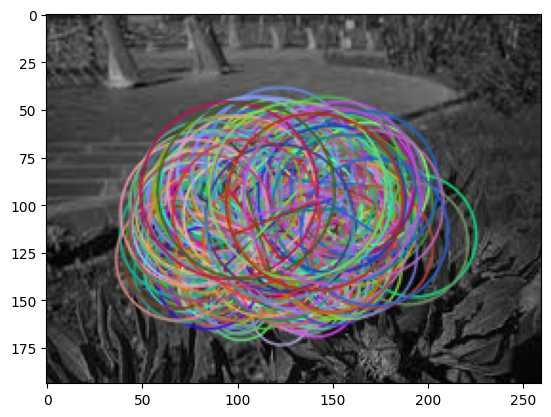

In [4]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
import os

def ORB():
    root=os.getcwd()
    imgpath=cv.imread("flower.jpeg")
    imgGray=cv.cvtColor(imgpath,cv.COLOR_BGR2GRAY)

    orb=cv.ORB_create()
    keypoints=orb.detect(imgGray,None)
    keypoints,_ = orb.compute(imgGray,keypoints)
    imgGray=cv.drawKeypoints(imgGray,keypoints,imgGray,flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    plt.figure()
    plt.imshow(imgGray)
    plt.show()






if __name__ == "__main__":
    ORB()

(np.float64(-0.5), np.float64(259.5), np.float64(193.5), np.float64(-0.5))

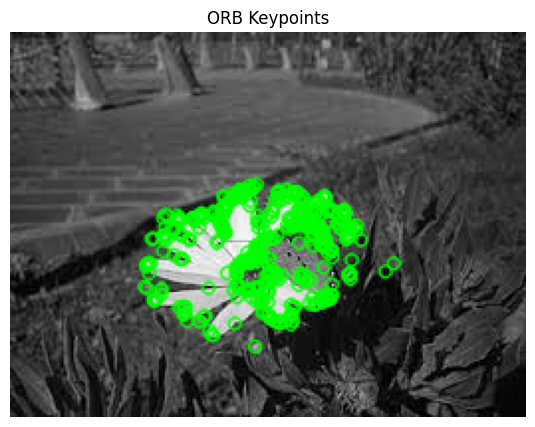

In [3]:
import cv2
import matplotlib.pyplot as plt

# Görüntüyü yükle
img = cv2.imread("flower.jpeg", cv2.IMREAD_GRAYSCALE)

# ORB nesnesi oluştur
orb = cv2.ORB_create()

# Keypoint ve descriptor çıkar
keypoints, descriptors = orb.detectAndCompute(img, None)

# Keypoint’leri görselleştir
img_keypoints = cv2.drawKeypoints(img, keypoints, None, color=(0,255,0))
plt.figure(figsize=(10, 5))
plt.imshow(img_keypoints)
plt.title('ORB Keypoints')
plt.axis('off')



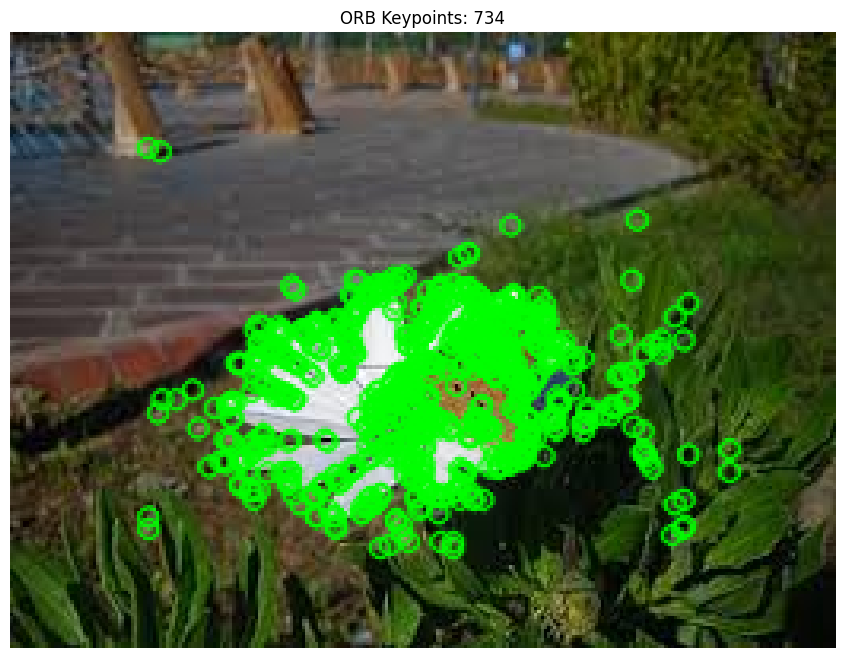

In [13]:
def orb_feature_extraction(image_path):
    # Görüntüyü yükle
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # ORB detektörü oluştur
    orb = cv2.ORB_create(nfeatures=1000)
    
    # Keypoint ve tanımlayıcıları bul
    keypoints, descriptors = orb.detectAndCompute(gray, None)
    
    # Keypoint'leri çiz
    result_image = cv2.drawKeypoints(image, keypoints, None, color=(0, 255, 0), flags=0)
    
    plt.figure(figsize=(12, 8))
    plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
    plt.title(f'ORB Keypoints: {len(keypoints)}')
    plt.axis('off')
    plt.show()
    
    return keypoints, descriptors

# Kullanım
keypoints, descriptors = orb_feature_extraction('flower.jpeg')

Keypoint ve Özellik Çıkarımı Demo


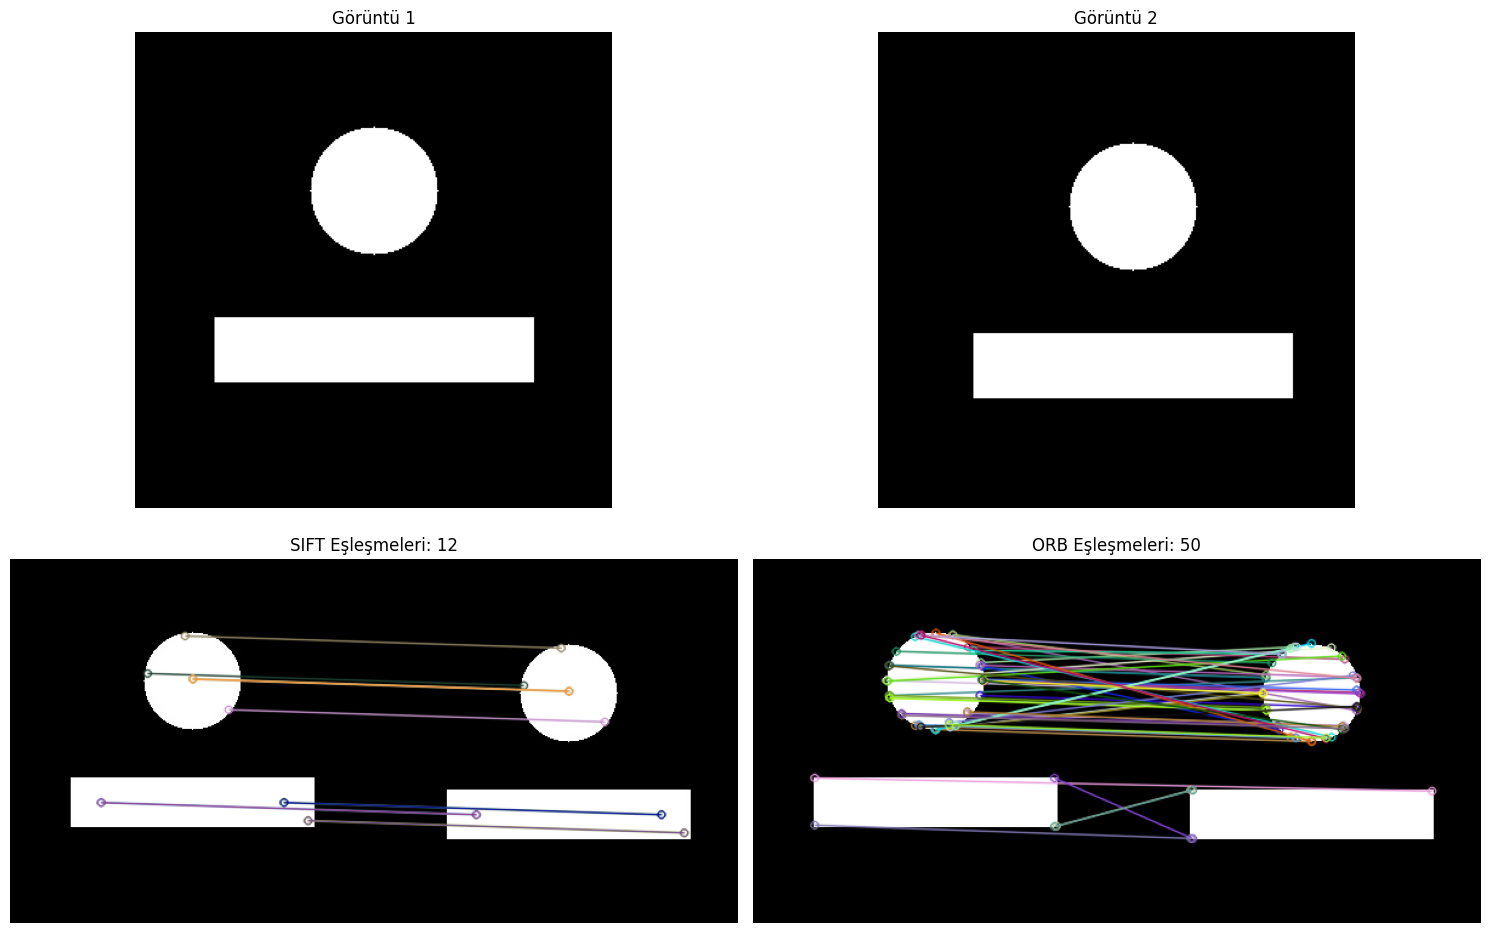

SIFT Keypoints - Görüntü 1: 14, Görüntü 2: 13
ORB Keypoints - Görüntü 1: 127, Görüntü 2: 126

Demo tamamlandı!


In [16]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def sift_feature_detection(img1_path, img2_path):
    """SIFT ile keypoint tespiti ve eşleştirme"""
    
    # Görüntüleri yükle
    img1 = cv2.imread(img1_path)
    img2 = cv2.imread(img2_path)
    
    # Gri tonlamaya çevir
    gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    
    # SIFT detektörü oluştur
    sift = cv2.SIFT_create()
    
    # Keypoint ve descriptor'ları bul
    kp1, des1 = sift.detectAndCompute(gray1, None)
    kp2, des2 = sift.detectAndCompute(gray2, None)
    
    # BFMatcher oluştur
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1, des2, k=2)
    
    # Lowe's ratio test uygula
    good_matches = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good_matches.append(m)
    
    # Eşleşmeleri çiz
    result = cv2.drawMatches(img1, kp1, img2, kp2, good_matches, None, 
                           flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    
    return result, len(good_matches), kp1, kp2

def orb_feature_detection(img1_path, img2_path):
    """ORB ile keypoint tespiti ve eşleştirme"""
    
    # Görüntüleri yükle
    img1 = cv2.imread(img1_path)
    img2 = cv2.imread(img2_path)
    
    # Gri tonlamaya çevir
    gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    
    # ORB detektörü oluştur
    orb = cv2.ORB_create()
    
    # Keypoint ve descriptor'ları bul
    kp1, des1 = orb.detectAndCompute(gray1, None)
    kp2, des2 = orb.detectAndCompute(gray2, None)
    
    # BFMatcher oluştur (HAMMING mesafesi ile)
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    
    # Eşleştirme yap
    matches = bf.match(des1, des2)
    
    # Mesafeye göre sırala
    matches = sorted(matches, key=lambda x: x.distance)
    
    # İlk 50 eşleşmeyi al
    good_matches = matches[:50]
    
    # Eşleşmeleri çiz
    result = cv2.drawMatches(img1, kp1, img2, kp2, good_matches, None, 
                           flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    
    return result, len(good_matches), kp1, kp2

def feature_matching_demo():
    """Örnek görüntülerle feature matching demo"""
    
    # Örnek görüntü oluştur (gerçek uygulamada dosya yollarını kullanın)
    # Bu örnekte basit geometrik şekiller oluşturuyoruz
    img1 = np.zeros((300, 300, 3), dtype=np.uint8)
    img2 = np.zeros((300, 300, 3), dtype=np.uint8)
    
    # İlk görüntüde daire ve dikdörtgen çiz
    cv2.circle(img1, (150, 100), 40, (255, 255, 255), -1)
    cv2.rectangle(img1, (50, 180), (250, 220), (255, 255, 255), -1)
    
    # İkinci görüntüde biraz kaydırılmış ve döndürülmüş versiyon
    cv2.circle(img2, (160, 110), 40, (255, 255, 255), -1)
    cv2.rectangle(img2, (60, 190), (260, 230), (255, 255, 255), -1)
    
    # Görüntüleri kaydet
    cv2.imwrite('img1.jpg', img1)
    cv2.imwrite('img2.jpg', img2)
    
    # SIFT ile eşleştirme
    sift_result, sift_matches, sift_kp1, sift_kp2 = sift_feature_detection('img1.jpg', 'img2.jpg')
    
    # ORB ile eşleştirme
    orb_result, orb_matches, orb_kp1, orb_kp2 = orb_feature_detection('img1.jpg', 'img2.jpg')
    
    # Sonuçları göster
    plt.figure(figsize=(15, 10))
    
    plt.subplot(2, 2, 1)
    plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
    plt.title('Görüntü 1')
    plt.axis('off')
    
    plt.subplot(2, 2, 2)
    plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
    plt.title('Görüntü 2')
    plt.axis('off')
    
    plt.subplot(2, 2, 3)
    plt.imshow(cv2.cvtColor(sift_result, cv2.COLOR_BGR2RGB))
    plt.title(f'SIFT Eşleşmeleri: {sift_matches}')
    plt.axis('off')
    
    plt.subplot(2, 2, 4)
    plt.imshow(cv2.cvtColor(orb_result, cv2.COLOR_BGR2RGB))
    plt.title(f'ORB Eşleşmeleri: {orb_matches}')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Keypoint sayılarını yazdır
    print(f"SIFT Keypoints - Görüntü 1: {len(sift_kp1)}, Görüntü 2: {len(sift_kp2)}")
    print(f"ORB Keypoints - Görüntü 1: {len(orb_kp1)}, Görüntü 2: {len(orb_kp2)}")
    
    return sift_result, orb_result

def real_image_example():
    """Gerçek görüntülerle örnek (kendi görüntülerinizi kullanın)"""
    
    # Kendi görüntü dosya yollarınızı buraya ekleyin
    try:
        # SIFT ile gerçek görüntü işleme
        sift_real, sift_count, _, _ = sift_feature_detection('real_img1.jpg', 'real_img2.jpg')
        
        # ORB ile gerçek görüntü işleme
        orb_real, orb_count, _, _ = orb_feature_detection('real_img1.jpg', 'real_img2.jpg')
        
        plt.figure(figsize=(12, 6))
        
        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(sift_real, cv2.COLOR_BGR2RGB))
        plt.title(f'Real Images - SIFT Matches: {sift_count}')
        plt.axis('off')
        
        plt.subplot(1, 2, 2)
        plt.imshow(cv2.cvtColor(orb_real, cv2.COLOR_BGR2RGB))
        plt.title(f'Real Images - ORB Matches: {orb_count}')
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"Gerçek görüntü yüklenirken hata: {e}")
        print("Lütfen 'real_img1.jpg' ve 'real_img2.jpg' dosyalarını oluşturun")

# Ana program
if __name__ == "__main__":
    print("Keypoint ve Özellik Çıkarımı Demo")
    print("=" * 40)
    
    # Demo çalıştır
    sift_result, orb_result = feature_matching_demo()
    
    # Gerçek görüntü örneği (yorum satırını kaldırın ve görüntüleri ekleyin)
    # real_image_example()
    
    print("\nDemo tamamlandı!")